In [45]:
import matplotlib
import PIL
import os
import pandas as pd
import random
import cv2
from matplotlib import pyplot as plt
import albumentations as A

# splits original images to several of one size
def split_images(annotations, num_splits=4):
    '''
    num_splits: Must be square of a number
    '''
    global annotations_filename, images_path_list
    def is_square(apositiveint):
        x = apositiveint // 2
        seen = set([x])
        while x * x != apositiveint:
            x = (x + (apositiveint // x)) // 2
            if x in seen: return False
            seen.add(x)
        return True
    def root_closest_devisors(number):
        if number < 4:
            return 1
        divisor = 1
        for i in range(2, number):
            if i * i == number:
                return i, i
            if i * i < number and number % i == 0:
                divisor = i
            if i * i > number:
                return divisor, int(number / divisor)

    origin_images_directory_list = list(map(lambda path: os.fsencode(path + 'origin/'), images_path_list))
    modified_images_path_list = list(map(lambda path: path + 'changed/', images_path_list))
    

    delta = 220
    delta2 = int(delta/2)
    im_size1 = 3264
    im_size1_half = int(im_size1/2)
    im_size2 = 2448
    size2_half = int(im_size2/2)
    split_x, split_y = root_closest_devisors(num_splits)
    step_x1, step_y1 = int(im_size1 / split_x), int((im_size2 - delta) / split_y)
    step_x2, step_y2 = int(im_size2 / split_x), int((im_size1 - delta) / split_y)
    main_crop1 = (0, 0, im_size1, im_size2 - delta)
    main_crop2 = (0, 0, im_size2, im_size1 - delta)
    crop_coords1 = tuple(
        (step_x1 * i, step_y1 * j, step_x1 * (i+1), step_y1 * (j+1)) for i in range(split_x) for j in range(split_y)
    )
    crop_coords2 = tuple(
        (step_x2 * j, step_y2 * i, step_x2 * (j+1), step_y2 * (i+1)) for j in range(split_y) for i in range(split_x)
    )
    for origin_images_directory, modified_imgs_path, path in zip(origin_images_directory_list, modified_images_path_list, images_path_list):
        if not os.path.isfile(path+annotations_filename):
            continue
        annotated_files_unchanged_names = annotations[annotations['dataset_dir'] == path]['filename'].apply(lambda x: x.split('_changed')[0] + '.jpg')
        changed_imgs_series = pd.Series(os.listdir(os.fsencode(modified_imgs_path))).apply(os.fsdecode)
        changed_imgs_series.index = changed_imgs_series.apply(lambda x: x.split('_changed')[0] + '.jpg')
        for file in os.listdir(origin_images_directory)[1:]:
            filename = os.fsdecode(file)
            # Don't rewrite annotated images
            if filename in annotated_files_unchanged_names.values:
                continue
            # Check if unannotated images have different split number
            if filename in changed_imgs_series.index:
                nums = changed_imgs_series[changed_imgs_series.index == filename].apply(lambda x: int(x.split('.')[0].split('_changed')[1])).sort_values(ascending=False)
                i = 0
                while nums.values[i] > num_splits:
                    os.remove(modified_imgs_path + nums.index[i].split('.')[0] + '_changed'+str(nums.values[i])+'.jpg')
                    i += 1
            # split image to num_splits images
            with PIL.Image.open(path + 'origin/' + filename) as img:
                PIL.ImageOps.exif_transpose(img, in_place=True)
                if img.height == im_size2:
                    img2 = img.crop(main_crop1)
                    for i in range(split_x):
                        for j in range(split_y):
                            img2.crop(crop_coords1[i*split_x+j]).save('{}changed/{}_changed{}.jpg'.format(path, filename.split('.')[0], i*split_x+j+1))
                elif img.height == im_size1:
                    img2 = img.crop(main_crop2)
                    for i in range(split_x):
                        for j in range(split_y):
                            img2.crop(crop_coords2[i*split_x+j]).save('{}changed/{}_changed{}.jpg'.format(path, filename.split('.')[0], i*split_x+j+1))

# reads mask annotations file
def read_mask_annotations_file(images_path_list=['../../data/dice/dice_photoset_2/'], annotations_filename='dice_set2_json.json', drop_empty_annotations=False):
    annotations_list = []
    for path in images_path_list:
        if not os.path.isfile(path + annotations_filename):
            continue
        annotations_list.append(pd.read_json(path + annotations_filename).T)
        if drop_empty_annotations:
            annotations_list[-1] = annotations_list[-1][annotations_list[-1]['regions'].str.len() != 0]
        # negative box coordinates check and fix
        for id in annotations_list[-1].index:
            for reg_id in range(len(annotations_list[-1].loc[id, 'regions'])):
                annotations_list[-1].loc[id, 'regions'][reg_id]['shape_attributes']['all_points_x'] = list(map(lambda x: 0 if x < 0 else x, annotations_list[-1].loc[id, 'regions'][reg_id]['shape_attributes']['all_points_x']))
                annotations_list[-1].loc[id, 'regions'][reg_id]['shape_attributes']['all_points_y'] = list(map(lambda x: 0 if x < 0 else x, annotations_list[-1].loc[id, 'regions'][reg_id]['shape_attributes']['all_points_y']))
        annotations_list[-1]['dataset_dir'] = path
    return pd.concat(annotations_list, axis=0)

# turn mask annotations to object detection annotations
def dice_mask_polygon_annotation_to_rectangle_object_detection_annotation(path_list, filename):
    new_annotations_list = []
    for path in path_list:
        if not os.path.isfile(path + annotations_filename):
            continue
        annotations_old = pd.read_json(path + filename).T
        # annotations_old = annotations_old[annotations_old['regions'].str.len() != 0]
        annotations_new = annotations_old.copy()
        annotations_new.loc[:, 'regions'] = annotations_old.loc[:, 'regions'].apply(lambda x: list(map(lambda y: 
                                                                {"shape_attributes" : {"name":"rect","x":min(y['shape_attributes']['all_points_x']) if min(y['shape_attributes']['all_points_x']) > 0 else 0,"y":min(y['shape_attributes']['all_points_y']) if min(y['shape_attributes']['all_points_y']) > 0 else 0,
                                                                        "width":max(y['shape_attributes']['all_points_x'])-(min(y['shape_attributes']['all_points_x']) if min(y['shape_attributes']['all_points_x']) > 0 else 0),
                                                                        "height":max(y['shape_attributes']['all_points_y'])-(min(y['shape_attributes']['all_points_y']) if min(y['shape_attributes']['all_points_y']) > 0 else 0)}, "region_attributes":{"dice_value":y['region_attributes']['dice_value']}},
                                                                x)) if x is not [] else print(x))
        annotations_new['dataset_dir'] = path
        new_annotations_list.append(annotations_new)
    return new_annotations_list

images_path_list = [
    '../../data/dice/dice_photoset_2/',
    '../../data/dice/dice_photoset_3/',
]
annotations_filename = 'dice_set_json.json'

In [34]:
# ORIGIN IMAGE SPLITTING
# First read annotations files (need for correct image split) and concatenate to general dataframe
annotations = read_mask_annotations_file(images_path_list, annotations_filename, drop_empty_annotations=False)

# split original images to many images
split_images(num_splits=9, annotations=annotations)

In [39]:
# ANNOTATIONS FILE PROCESSING
# read annotations file
annotations = read_mask_annotations_file(images_path_list, annotations_filename, drop_empty_annotations=False)

for path in annotations['dataset_dir'].unique():
    # read image sizes 
    directory = os.fsencode(path + 'changed')
    image_size_dir = {}
    dir_list = os.listdir(directory)
    for file in dir_list:
        filename = os.fsdecode(file)
        with PIL.Image.open(path + 'changed/' + filename) as img:
            image_size_dir[filename] = list((img.width, img.height))

    # merge annotations and image sizes
    image_size_dirr = pd.DataFrame(data=[image_size_dir.values(), image_size_dir.keys()]).T
    image_size_dirr.columns = ['image_size', 'filename']
    df_addition = pd.DataFrame(data=annotations[annotations['dataset_dir'] == path].values, columns=list(annotations[annotations['dataset_dir'] == path].columns))
    df_addition = pd.merge(df_addition, image_size_dirr)
    df = df_addition if 'df' in globals() else pd.concat([df, df_addition], axis=0)

In [46]:
# TURN MASKS ANNOTATIONS TO OBJECT DETECTION ANNOTATIONS
obj_det_annotations_list = dice_mask_polygon_annotation_to_rectangle_object_detection_annotation(images_path_list, annotations_filename)
for obj_det_annotations in obj_det_annotations_list:
    obj_det_annotations.T.to_json(obj_det_annotations['dataset_dir'][0] + annotations_filename.split('.')[0] + '_object_detection.json')
obj_det_annotations = pd.concat(obj_det_annotations_list, axis=0)

C:\Temp\ipykernel_11548\2256511028.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obj_det_annotations.T.to_json(obj_det_annotations['dataset_dir'][0] + annotations_filename.split('.')[0] + '_object_detection.json')


1. СПЛИТИМ КАРТИНКИ НА ЧАСТИ
2. РАЗМЕЧАЕМ ДАННЫЕ В VGG РАЗМЕЧАТЕЛЕ
3. ДЕЛИМ ДАТАСЕТ НА ТРЕЙН, ТЕСТ, ВАЛ (СТРУКТУРА ДАТАСЕТА: ПАПКИ ТЕСТ, ТРЕЙН, ВАЛ, В НИХ ПАПКИ ЛЕЙБЛС, ИМАДЖЕС) (сохранить струкуру оригинального датасета отдельно)
4. ПРОВОДИМ АУГМЕНТАЦИЮ ПО КАЖДОМУ ДАТАСЕТУ ПО ОТДЕЛЬНОСТИ

In [55]:
# augmentations prepare
import shutil
import os.path
import numpy as np
from sklearn.model_selection import train_test_split

BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

new_dataset_dir_path = 'datasets/Dice-detection-3/'
origin_dataset_dir_path_list = list(map(lambda path: path + 'changed/', images_path_list))
subdirs = ['train/', 'test/', 'valid/']
subsubdirs = ['images/', 'labels/']

# create dirs structure for images and labels of yolo dataset
def new_object_detection_dataset_structure_create(general_df, overwrite_files=False, predelete_all_files=False, test_size=0.1, val_size=0.2):
    global new_dataset_dir_path, origin_dataset_dir_path_list, subdirs, subsubdirs
    overwrite_files = not overwrite_files # костыль
    os.makedirs(new_dataset_dir_path, exist_ok = True)
    for s in subdirs:
        os.makedirs(new_dataset_dir_path+s, exist_ok = True)
        for ss in subsubdirs:
            os.makedirs(new_dataset_dir_path+s+ss, exist_ok = True)
    for origin_dataset_dir_path in origin_dataset_dir_path_list:
        df = general_df[general_df['dataset_dir'] == origin_dataset_dir_path[:-8]]
        data_len = len(df)
        if not data_len:
            continue
        idx_train, idx_test = train_test_split(np.arange(data_len), test_size=test_size, random_state=1)
        val_size = val_size/(1 - test_size)
        idx_train, idx_val = train_test_split(idx_train, test_size=val_size, random_state=1) # 0.25 x 0.8 = 0.2
        def delete_files(file_path):
            ultimate_path = file_path+subsubdirs[0]
            for file in os.listdir(ultimate_path):
                os.remove(ultimate_path+file)
            ultimate_path = file_path+subsubdirs[1]
            for file in os.listdir(ultimate_path):
                os.remove(ultimate_path+file)
        def copy_images(file_path, idx_list):
            for fl in df['filename'][idx_list].values:
                if os.path.isfile(file_path+fl) and overwrite_files:
                    print('File exists', fl)
                else:
                    shutil.copyfile(origin_dataset_dir_path+fl, file_path+fl)
        if predelete_all_files:
            delete_files(new_dataset_dir_path+subdirs[0])
            delete_files(new_dataset_dir_path+subdirs[1])
            delete_files(new_dataset_dir_path+subdirs[2])
        copy_images(new_dataset_dir_path+subdirs[0]+subsubdirs[0], idx_train)
        copy_images(new_dataset_dir_path+subdirs[1]+subsubdirs[0], idx_test)
        copy_images(new_dataset_dir_path+subdirs[2]+subsubdirs[0], idx_val)
        def boxes_to_labels(file_path, idx_list):
            for idx in idx_list:
                fl, rg, sz = df.loc[idx, 'filename'], df.loc[idx, 'regions'], df.loc[idx, 'image_size']
                tfl = fl.split('.')[0]+'.txt'
                if os.path.isfile(file_path+tfl) and overwrite_files:
                    print('File exists', tfl)
                else:
                    f = open(file_path+tfl, 'w')
                    class_list = list(map(lambda x: x['region_attributes']['dice_value'], rg))
                    IMAGE_SIZE_X, IMAGE_SIZE_Y = sz[0], sz[1]
                    box_list = list(map(lambda x: [(x['shape_attributes']['x']+x['shape_attributes']['width']/2)/IMAGE_SIZE_X, 
                                                (x['shape_attributes']['y']+x['shape_attributes']['height']/2)/IMAGE_SIZE_Y, 
                                                x['shape_attributes']['width']/IMAGE_SIZE_X, 
                                                x['shape_attributes']['height']/IMAGE_SIZE_Y] if (x['shape_attributes']['x']+x['shape_attributes']['width']/2)/IMAGE_SIZE_X < 1 and (x['shape_attributes']['y']+x['shape_attributes']['height']/2)/IMAGE_SIZE_Y < 1 else [], rg))
                    for i in range(len(class_list)):
                        if len(box_list[i]) != 0 and len(class_list[i]) != 0: # check if dice value is empty
                            f.write(" ".join(map(str, [int(class_list[i])-1, box_list[i][0], box_list[i][1], box_list[i][2], box_list[i][3]]))+'\n')
                    f.close()
        boxes_to_labels(new_dataset_dir_path+subdirs[0]+subsubdirs[1], idx_train)
        boxes_to_labels(new_dataset_dir_path+subdirs[1]+subsubdirs[1], idx_test)
        boxes_to_labels(new_dataset_dir_path+subdirs[2]+subsubdirs[1], idx_val)


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name, to_print=False):
    img = image.copy()
    if to_print:
        print(bboxes, category_ids, category_id_to_name)
    for bbox, category_id in zip(bboxes, category_ids):
        if to_print:
            print(bbox, category_id)
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [56]:
# prepare dirs structure (train, test, val), creating dataset (copying images, creating corresponding labels files)
modified_obj_det_df = pd.merge(obj_det_annotations, image_size_dirr, on='filename')
new_object_detection_dataset_structure_create(general_df=modified_obj_det_df,overwrite_files=False, predelete_all_files=False)

File exists P_20240928_215510_changed1.jpg
File exists P_20240928_220353_changed3.jpg
File exists P_20241008_200121_changed1.jpg
File exists P_20240928_215507_changed1.jpg
File exists P_20240928_215355_changed1.jpg
File exists P_20241008_200124_changed5.jpg
File exists P_20241008_200117_changed5.jpg
File exists P_20241008_195819_changed3.jpg
File exists P_20240928_215653_changed2.jpg
File exists P_20240928_215417_changed2.jpg
File exists P_20240928_215504_changed3.jpg
File exists P_20241008_200124_changed4.jpg
File exists P_20241008_200332_changed2.jpg
File exists P_20240928_215504_changed4.jpg
File exists P_20241008_195623_changed4.jpg
File exists P_20241008_195623_changed5.jpg
File exists P_20241008_195826_changed7.jpg
File exists P_20241008_200006_changed3.jpg
File exists P_20240928_215405_changed3.jpg
File exists P_20241008_200121_changed8.jpg
File exists P_20241008_195832_changed8.jpg
File exists P_20241008_200006_changed1.jpg
File exists P_20240928_215413_changed4.jpg
File exists

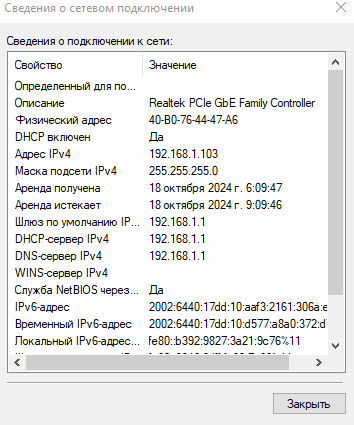

In [31]:
# image and object frame augmentations (pipeline ver)
import PIL.Image
import albumentations as A
import pandas as pd
import cv2
import PIL
import numpy as np
import os

def augmentate_object_detection(
        datasets:str='train',
        image_number_scale_coef:int=1, 
        transform:A.Compose=None, 
        dataset_samples_limit:int=None,
        save_or_visualize:tuple=(False, True),
        remove_augmented:bool=True,
        ):
    '''
    datasets: can have values 'train', 'test', 'val', 'all'
    image_labels_directory_path: Example image_labels_directory_path='./datasets/Dice-detection-3/test/'
    '''
    global new_dataset_dir_path, subdirs, subsubdirs
    if image_number_scale_coef < 1:
        return "No images are generated"
    if datasets == 'all':
        image_directory_path_list = [new_dataset_dir_path+subdirs[0]+subsubdirs[0], new_dataset_dir_path+subdirs[1]+subsubdirs[0], new_dataset_dir_path+subdirs[2]+subsubdirs[0]]
        labels_directory_path_list = [new_dataset_dir_path+subdirs[0]+subsubdirs[1], new_dataset_dir_path+subdirs[1]+subsubdirs[1], new_dataset_dir_path+subdirs[2]+subsubdirs[1]]
    elif datasets == 'train':
        image_directory_path_list = [new_dataset_dir_path+subdirs[0]+subsubdirs[0]]
        labels_directory_path_list = [new_dataset_dir_path+subdirs[0]+subsubdirs[1]]
    elif datasets == 'test':
        image_directory_path_list = [new_dataset_dir_path+subdirs[1]+subsubdirs[0]]
        labels_directory_path_list = [new_dataset_dir_path+subdirs[1]+subsubdirs[1]]
    elif datasets == 'val':
        image_directory_path_list = [new_dataset_dir_path+subdirs[2]+subsubdirs[0]]
        labels_directory_path_list = [new_dataset_dir_path+subdirs[2]+subsubdirs[1]]
    if save_or_visualize[1]:
        category_id_to_name = {0: 'dice_1', 1: 'dice_2', 2: 'dice_3', 3: 'dice_4', 4: 'dice_5', 5: 'dice_6', 6: 'undetectable'}
    if transform is None:
        transform = A.Compose([
            # A.BBoxSafeRandomCrop(erosion_rate=0.8, p=1.0, always_apply=False),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=(-0.5, 0.0625), scale_limit=(-0.1, 0.1), rotate_limit=(-45, 45), interpolation=1, border_mode=4, value=0, mask_value=0, shift_limit_x=None, shift_limit_y=None, rotate_method='largest_box', always_apply=None, p=1),
            A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
            A.RandomBrightnessContrast(p=0.2),
        ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.6))
    def boxes_to_labels(file_path, boxes, class_labels):
        if os.path.isfile(file_path):
            print('File exists', file_path)
        else:
            f = open(file_path, 'w')
            for i in range(len(class_labels)):
                if len(boxes[i]) != 0:
                    f.write(" ".join(map(str, [int(class_labels[i]), boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]]))+'\n')
            f.close()
    exception_counter = 0
    # iterate through all chosen directories (train, test...)
    for dir_id in range(len(image_directory_path_list)):
        i = 0 # directory files number
        # first remove augmented images from dataset if needed
        if remove_augmented:
            for image_filename_bin in os.listdir(image_directory_path_list[dir_id]):
                image_filename = os.fsdecode(image_filename_bin)
                if len(image_filename.split('augmented')) > 1:
                    os.remove(image_directory_path_list[dir_id]+image_filename)
            for image_filename_bin in os.listdir(labels_directory_path_list[dir_id]):
                image_filename = os.fsdecode(image_filename_bin)
                if len(image_filename.split('augmented')) > 1:
                    os.remove(labels_directory_path_list[dir_id]+image_filename)
        # limit augmented image number
        if dataset_samples_limit is not None:
            dir_files_list = os.listdir(image_directory_path_list[dir_id])[:dataset_samples_limit]
        else:
            dir_files_list = os.listdir(image_directory_path_list[dir_id])
        # generate augmented images
        for image_filename_bin in dir_files_list:
            image_filename = os.fsdecode(image_filename_bin)
            filename_clear = image_filename.split('.')[0]
            with open(labels_directory_path_list[dir_id]+filename_clear+'.txt', 'r') as labels_file:
                lines = [line.rstrip() for line in labels_file]
            image, boxes, labeles = cv2.cvtColor(np.array(PIL.Image.open(image_directory_path_list[dir_id]+image_filename)), cv2.COLOR_BGR2RGB), \
                list(map(lambda x: list(map(float, x.split(' ')[1:])), lines)), \
                    list(map(lambda x: int(x.strip(' ')[0]), lines))
            image = np.array(PIL.Image.open(image_directory_path_list[dir_id]+image_filename))
            # generated_dir = {
            #     'images': [],
            #     'boxes': [],
            #     'class_labels': [],
            #                  }
            # generating process
            print(image_directory_path_list[dir_id]+image_filename)
            for j in range(image_number_scale_coef):
                try:
                    transformed = transform(image=image, bboxes=boxes, class_labels=labeles)
                    if len(transformed['bboxes']) != 0:
                        i += 1
                    if save_or_visualize[1]:
                        visualize(transformed['image'], [[x[0]*image.shape[1] - x[2]*image.shape[1]/2, x[1]*image.shape[0]-x[3]*image.shape[0]/2, x[2]*image.shape[1], x[3]*image.shape[0]] for x in transformed['bboxes']], transformed['class_labels'], category_id_to_name)
                except:
                    exception_counter += 1
                    print(transformed['class_labels'])
                    print(image_directory_path_list[dir_id]+image_filename, '  caused exception')
                # generated_dir['images'] = transformed['image']
                # generated_dir['boxes'] = transformed['bboxes']
                # generated_dir['class_labels'] = transformed['class_labels']
                if save_or_visualize[0]:
                    print(image_filename.split('.')[0]+'_augmented_'+str(j+1)+'.jpg')
                    PIL.Image.fromarray(transformed['image']).save(image_directory_path_list[dir_id]+image_filename.split('.')[0]+'_augmented_'+str(j+1)+'.jpg')
                    boxes_to_labels(labels_directory_path_list[dir_id]+image_filename.split('.')[0]+'_augmented_'+str(j+1)+'.txt', transformed['bboxes'], transformed['class_labels'])
            
            # print(boxes, transformed_bboxes)
            # print(labeles, transformed_class_labels)
            # display(PIL.Image.fromarray(transformed_image))
            # print(len(transformed_bboxes), transformed_class_labels, category_id_to_name)
        print(len(dir_files_list), i)
    print('Unprocessed', exception_counter)
    return

transforms = [
    # A.BBoxSafeRandomCrop(erosion_rate=0.8, p=1.0, always_apply=False),
    # A.PiecewiseAffine (scale=(0.03, 0.05), nb_rows=(4, 4), nb_cols=(4, 4), interpolation=1, mask_interpolation=0, cval=0, cval_mask=0, mode='constant', absolute_scale=False, always_apply=None, keypoints_threshold=0.01, p=1),    
    # A.Perspective (scale=(0.05, 0.1), keep_size=False, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=True, interpolation=1, always_apply=None, p=1),
    # A.PadIfNeeded (min_height=1024, min_width=1024, pad_height_divisor=None, pad_width_divisor=None, position='center', border_mode=4, value=None, mask_value=None, always_apply=None, p=1.0),
    # A.GridElasticDeform (num_grid_xy, magnitude, interpolation=1, mask_interpolation=0, p=1.0, always_apply=None),
    # A.ShiftScaleRotate(shift_limit=(-0.5, 0.0625), scale_limit=(-0.1, 0.1), rotate_limit=(-45, 45), interpolation=1, border_mode=0, value=0, mask_value=0, shift_limit_x=None, shift_limit_y=None, rotate_method='ellipse', always_apply=None, p=1),
    
    A.GridDistortion (num_steps=4, distort_limit=(-0.5, 0.5), interpolation=1, border_mode=4, value=None, mask_value=None, normalized=True, always_apply=None, p=0.35),
    A.OpticalDistortion (distort_limit=(-0.20, 0.20), shift_limit=(-0.4, 0.4), interpolation=1, border_mode=0, value=None, mask_value=None, always_apply=None, p=0.35),
    A.ElasticTransform (alpha=35, sigma=40, interpolation=2, border_mode=1, value=None, mask_value=None, always_apply=True, approximate=False, same_dxdy=False, p=0.35),
    A.Affine (scale=(0.5, 2), translate_percent=(-0.6, 0.6), translate_px=None, rotate=(-120, 120), shear=(-20, 20), interpolation=1, mask_interpolation=0, cval=0, cval_mask=0, mode=0, fit_output=False, keep_ratio=False, rotate_method='ellipse', balanced_scale=True, always_apply=None, p=0.3),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RGBShift(r_shift_limit=100, g_shift_limit=100, b_shift_limit=100, p=0.35),
    A.RandomBrightnessContrast(brightness_limit = (-0.2, 0.2), contrast_limit = (-0.2, 0.2), p=0.35),
]
transform = A.Compose(transforms, bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
augmentate_object_detection(datasets='all', image_number_scale_coef=4, transform=transform, dataset_samples_limit=None, save_or_visualize=(True, False), remove_augmented=True)

datasets/Dice-detection-3/train/images/P_20240928_215338_changed1.jpg


P_20240928_215338_changed1_augmented_1.jpg
P_20240928_215338_changed1_augmented_2.jpg
P_20240928_215338_changed1_augmented_3.jpg
P_20240928_215338_changed1_augmented_4.jpg
datasets/Dice-detection-3/train/images/P_20240928_215338_changed3.jpg
P_20240928_215338_changed3_augmented_1.jpg
P_20240928_215338_changed3_augmented_2.jpg
P_20240928_215338_changed3_augmented_3.jpg
P_20240928_215338_changed3_augmented_4.jpg
datasets/Dice-detection-3/train/images/P_20240928_215338_changed4.jpg
P_20240928_215338_changed4_augmented_1.jpg
P_20240928_215338_changed4_augmented_2.jpg
P_20240928_215338_changed4_augmented_3.jpg
P_20240928_215338_changed4_augmented_4.jpg
datasets/Dice-detection-3/train/images/P_20240928_215349_changed2.jpg
P_20240928_215349_changed2_augmented_1.jpg
P_20240928_215349_changed2_augmented_2.jpg
P_20240928_215349_changed2_augmented_3.jpg
P_20240928_215349_changed2_augmented_4.jpg
datasets/Dice-detection-3/train/images/P_20240928_215349_changed4.jpg
P_20240928_215349_changed4_augme

c:\Users\Mihail\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\core\bbox_utils.py:476: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


P_20240928_215349_changed4_augmented_2.jpg
P_20240928_215349_changed4_augmented_3.jpg
P_20240928_215349_changed4_augmented_4.jpg
datasets/Dice-detection-3/train/images/P_20240928_215352_changed2.jpg
P_20240928_215352_changed2_augmented_1.jpg
P_20240928_215352_changed2_augmented_2.jpg
P_20240928_215352_changed2_augmented_3.jpg
P_20240928_215352_changed2_augmented_4.jpg
datasets/Dice-detection-3/train/images/P_20240928_215352_changed3.jpg
P_20240928_215352_changed3_augmented_1.jpg
P_20240928_215352_changed3_augmented_2.jpg
P_20240928_215352_changed3_augmented_3.jpg
P_20240928_215352_changed3_augmented_4.jpg
datasets/Dice-detection-3/train/images/P_20240928_215355_changed1.jpg
P_20240928_215355_changed1_augmented_1.jpg
P_20240928_215355_changed1_augmented_2.jpg
P_20240928_215355_changed1_augmented_3.jpg
P_20240928_215355_changed1_augmented_4.jpg
datasets/Dice-detection-3/train/images/P_20240928_215355_changed2.jpg
P_20240928_215355_changed2_augmented_1.jpg
P_20240928_215355_changed2_augme

In [58]:
# image and object frame augmentations
import PIL.Image
import albumentations as alb
import pandas as pd
import cv2
import PIL
import numpy as np

def augmentate_object_detection(image_labels_directory_path_list=None):
    transform = alb.Compose([
        alb.RandomCrop(width=450, height=450),
        alb.HorizontalFlip(p=0.5),
        alb.RandomBrightnessContrast(p=0.2),
    ], bbox_params=alb.BboxParams(format='coco', min_area=1024, min_visibility=0.1, label_fields=['class_labels']))
    bboxes_df = pd.read_json(path+'dice_set2_json_object_detection.json').T
    bboxes_df = bboxes_df[bboxes_df['regions'].str.len() != 0]
    bboxes_df = pd.DataFrame(index=bboxes_df['filename'].values, data=bboxes_df.values, columns=list(bboxes_df.columns)).drop(columns=['filename'])
    for id in bboxes_df.index:
        image, boxes, labeles = id, \
            list(map(lambda x: [x['shape_attributes']['x'], x['shape_attributes']['y'], x['shape_attributes']['width'], x['shape_attributes']['height']], bboxes_df.loc[id, 'regions'])),\
            list(map(lambda x: x['region_attributes']['dice_value'], bboxes_df.loc[id, 'regions']))
        image = cv2.cvtColor(np.array(PIL.Image.open(path+'changed/'+image)), cv2.COLOR_BGR2RGB)
        transformed = transform(image=image, bboxes=boxes, class_labels=labeles)
        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']
        transformed_class_labels = transformed['class_labels']
        display(PIL.Image.fromarray(transformed_image))
        PIL.Image.fromarray(image)

IndentationError: expected an indented block after function definition on line 9 (1976502728.py, line 11)

In [48]:
# ACTUAL
from PIL import ImagePath, Image, ImageDraw
import torch

for i in df.index:
    cords = []
    labels = []
    if_any_region_marked = 0 # КОСТЫЛЬ!!! УБРАТЬ ЛИШНИЕ РЕГИОНЫ С ПИКЧ!!!
    mask_id = 0
    for j in df.loc[i, 'regions']:
        if j['region_attributes']['dice_value'] == '':
            print(df.loc[i, 'filename'], j)
            continue
        if_any_region_marked += 1
        cords.append(tuple((min(j['shape_attributes']['all_points_x']), min(j['shape_attributes']['all_points_y']), max(j['shape_attributes']['all_points_x']), max(j['shape_attributes']['all_points_y']))))
        labels.append(int(j['region_attributes']['dice_value']))
        image = PIL.ImagePath.Path(list(zip(j['shape_attributes']['all_points_x'], j['shape_attributes']['all_points_y']))).getbbox()
        size = df.loc[i, 'image_size']
        img = Image.new("1", size, "black")
        img1 = ImageDraw.Draw(img)   
        img1.polygon(list(zip(j['shape_attributes']['all_points_x'], j['shape_attributes']['all_points_y'])), fill ="white")
        img.save(path + 'masks/' + df.loc[i, 'filename'].split('.')[0] + '_mask' + str(mask_id) + '.jpg')
        mask_id += 1
    if not if_any_region_marked:
        print('DROPPED', df.loc[i, :])
        df = df.drop(index=i)
    else:
        torch.save(torch.tensor(cords, dtype=torch.float), path + 'coordinates/' + df.loc[i, 'filename'].split('.')[0] + '_coordinates.pt')
        torch.save(torch.tensor(labels, dtype=torch.int64), path + 'labels/' + df.loc[i, 'filename'].split('.')[0] + '_labels.pt')
# df = df.reindex(axis=0)
pd.DataFrame(df['filename']).to_csv(path + 'filename.csv')

P_20240928_215349_changed2.jpg {'shape_attributes': {'name': 'polygon', 'all_points_x': [1266, 1230, 1276, 1309], 'all_points_y': [95, 146, 179, 130]}, 'region_attributes': {'dice_value': ''}}
P_20240928_215349_changed2.jpg {'shape_attributes': {'name': 'polygon', 'all_points_x': [1499, 1537, 1579, 1537], 'all_points_y': [145, 188, 150, 107]}, 'region_attributes': {'dice_value': ''}}
P_20240928_215349_changed2.jpg {'shape_attributes': {'name': 'polygon', 'all_points_x': [427, 423, 423, 428, 437, 449, 478, 486, 495, 482, 469, 442], 'all_points_y': [1359, 1345, 1326, 1312, 1300, 1292, 1288, 1292, 1332, 1355, 1366, 1369]}, 'region_attributes': {'dice_value': ''}}
P_20240928_215349_changed2.jpg {'shape_attributes': {'name': 'polygon', 'all_points_x': [391, 400, 418, 427, 438, 452, 463, 466, 437, 406, 394], 'all_points_y': [1501, 1483, 1455, 1447, 1444, 1450, 1458, 1473, 1521, 1521, 1511]}, 'region_attributes': {'dice_value': ''}}
P_20240928_215349_changed2.jpg {'shape_attributes': {'name':

In [ ]:
transform = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
], bbox_params=alb.BboxParams(format='coco', min_area=1024, min_visibility=0.1, label_fields=['class_labels']))

bboxes_df = pd.read_json(path+'dice_set2_json_object_detection.json').T
bboxes_df = bboxes_df[bboxes_df['regions'].str.len() != 0]
bboxes_df = pd.DataFrame(index=bboxes_df['filename'].values, data=bboxes_df.values, columns=list(bboxes_df.columns)).drop(columns=['filename'])
image, boxes, labeles = bboxes_df.index[0], \
    list(map(lambda x: [x['shape_attributes']['x'], x['shape_attributes']['y'], x['shape_attributes']['width'], x['shape_attributes']['height']], bboxes_df.loc[bboxes_df.index[0], 'regions'])),\
    list(map(lambda x: x['region_attributes']['dice_value'], bboxes_df.loc[bboxes_df.index[0], 'regions']))
image = PIL.Image.open(path+'changed/'+image)
image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)

class_labels = ['cat', 'dog', 'parrot']
transformed = transform(image=image, bboxes=boxes, class_labels=labeles)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['class_labels']
display(PIL.Image.fromarray(transformed_image))
PIL.Image.fromarray(image)

In [22]:

# path = 'C:/Users/Mihail/Desktop/Учёба/ML/data/dice/dice_photoset_2/'
# def split_images():
#     '''
#     num_splits: Must be square of a number
#     '''
#     directory = os.fsencode(path + 'origin/')

#     delta = 220
#     delta2 = int(delta/2)
#     im_size1 = 3264
#     im_size1_half = int(im_size1/2)
#     im_size2 = 2448
#     size2_half = int(im_size2/2)
#     boxes1 = ((0, 0, im_size1, im_size2 - delta),
#                 (0, 0, im_size1_half, size2_half - delta2),
#                 (0, size2_half - delta2, im_size1_half, im_size2 - delta),
#                 (im_size1_half, 0, im_size1, size2_half - delta2),
#                 (im_size1_half, size2_half - delta2, im_size1, im_size2 - delta),)
#     boxes2 = ((0, 0, im_size2, im_size1 - delta),
#                 (0, 0, size2_half, im_size1_half - delta2),   
#                 (0, im_size1_half - delta2, size2_half, im_size1 - delta),
#                 (size2_half, 0, im_size2, im_size1_half - delta2),
#                 (size2_half, im_size1_half - delta2, im_size2, im_size1 - delta),)
#     print(boxes2)
#     for file in os.listdir(directory)[1:]:
#         filename = os.fsdecode(file)
#         if filename in df['filename'].apply(lambda x: x.split('_changed')[0] + '.jpg').values:
#             continue
#         img = PIL.Image.open(path + 'origin/' + filename)
#         PIL.ImageOps.exif_transpose(img, in_place=True)
#         if img.height == im_size2:
#             boxes = boxes1
#         elif img.height == im_size1:
#             boxes = boxes2
#         img2 = img.crop(boxes[0])
#         img2.crop(boxes[1]).save(path + 'changed/' + filename.split('.')[0] + '_changed1.jpg')
#         img2.crop(boxes[2]).save(path + 'changed/' + filename.split('.')[0] + '_changed2.jpg')
#         img2.crop(boxes[3]).save(path + 'changed/' + filename.split('.')[0] + '_changed3.jpg')
#         img2.crop(boxes[4]).save(path + 'changed/' + filename.split('.')[0] + '_changed4.jpg')
# split_images()

((0, 0, 2448, 3044), (0, 0, 1224, 1522), (0, 1522, 1224, 3044), (1224, 0, 2448, 1522), (1224, 1522, 2448, 3044))


In [228]:
# from PIL import ImagePath, Image, ImageDraw
# import numpy as np
# image_size_dirr = pd.DataFrame(data=[image_size_dir.values(), image_size_dir.keys()]).T
# image_size_dirr.columns = ['image_size', 'filename']
# df = pd.DataFrame(data=annotations.values, columns=list(annotations.columns))
# df = pd.merge(df, image_size_dirr)
# output_df = pd.DataFrame(df['filename'])
# output_df['coordinates'] = [None for i in df.index]
# output_df['class_label'] = [None for i in df.index]
# # df['masks'] = [[] for i in df.index]
# masks = np.array([[] for i in df.index], dtype=int)
# for i in df.index:
#     cords = []
#     labels = []
#     for k,j in enumerate(df.loc[i, 'regions']):
#         cords.append(tuple((min(j['shape_attributes']['all_points_x']), min(j['shape_attributes']['all_points_y']), max(j['shape_attributes']['all_points_x']), max(j['shape_attributes']['all_points_y']))))
#         labels.append(j['region_attributes']['dice_value'])
#         image = PIL.ImagePath.Path(list(zip(j['shape_attributes']['all_points_x'], j['shape_attributes']['all_points_y']))).getbbox()
#         size = df.loc[i, 'image_size']
#         img = Image.new("1", size, "white")  
#         img1 = ImageDraw.Draw(img)   
#         img1.polygon(list(zip(j['shape_attributes']['all_points_x'], j['shape_attributes']['all_points_y'])), fill ="black")
#         img.save(path + 'masks/' + df.loc[i, 'filename'].split('.')[0] + '_mask' + str(k) + '.jpg')
#         np.append(masks[i], img)
#     output_df.at[i, 'coordinates'] = tuple(cords)
#     output_df.at[i, 'class_label'] = tuple(labels)
# np.save('masks.npy', masks, allow_pickle=True, fix_imports=True)
# output_df.to_csv('processed_data.csv')
# output_df.head()

,filename,coordinates,class_label
0,P_20240928_215338_changed1.jpg,"((360, 20, 456, 111), (474, 656, 587, 752), (5...","(5, 2, 1, 2, 6, 1, 1, 4, 5, 1, 6, 3)"
1,P_20240928_215338_changed2.jpg,"((1232, 156, 1328, 246), (980, 224, 1083, 322))","(6, 2)"
2,P_20240928_215338_changed3.jpg,"((80, 852, 153, 929), (207, 631, 311, 741), (3...","(5, 2, 3, 2, 4)"
3,P_20240928_215338_changed4.jpg,"((211, 37, 309, 131),)","(1,)"
4,P_20240928_215349_changed1.jpg,"((433, 1231, 505, 1296), (796, 1189, 880, 1274...","(3, 4, 2)"
5,P_20240928_215349_changed2.jpg,"((489, 49, 575, 131), (816, 7, 903, 91), (873,...","(4, 3, 1, 2, 3, 2, 5, 1, 3, 1, 3, 5, 2, 4, 5)"
6,P_20240928_215349_changed3.jpg,"((160, 1292, 242, 1378), (80, 1353, 159, 1427))","(6, 6)"
7,P_20240928_215349_changed4.jpg,"((4, 96, 89, 178), (275, 106, 357, 188), (548,...","(2, 3, 4, 5, 3, 3)"
8,P_20240928_215352_changed1.jpg,"((759, 1389, 845, 1471),)","(2,)"
9,P_20240928_215352_changed2.jpg,"((1457, 1, 1542, 77), (455, 749, 559, 851), (5...","(4, 3, 2, 6, 1, 1, 3, 4)"


In [174]:
image = cv2.imread('andrew9.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (0,0), fx=0.79, fy=0.78) 

bboxes = []# [[5.66, 138.95, 147.09, 164.88], [366.7, 80.84, 132.8, 181.84]]
category_ids = [17, 18]

# We will use the mapping from category_id to the class name
# to visualize the class label for the bounding box on the image
category_id_to_name = {17: 'cat', 18: 'dog'}


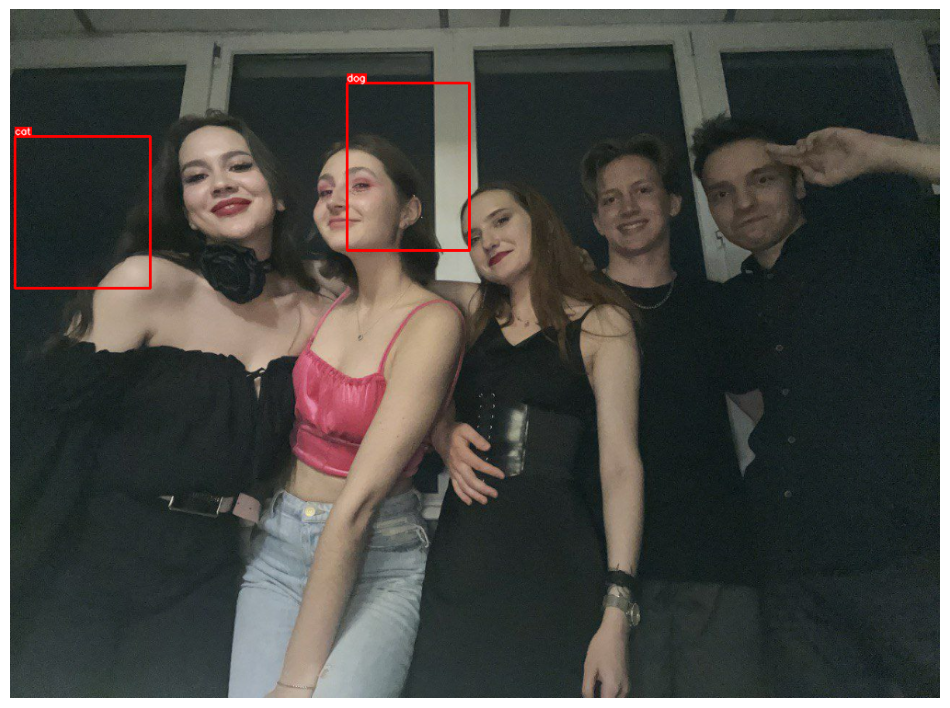

In [43]:
visualize(image, bboxes, category_ids, category_id_to_name)


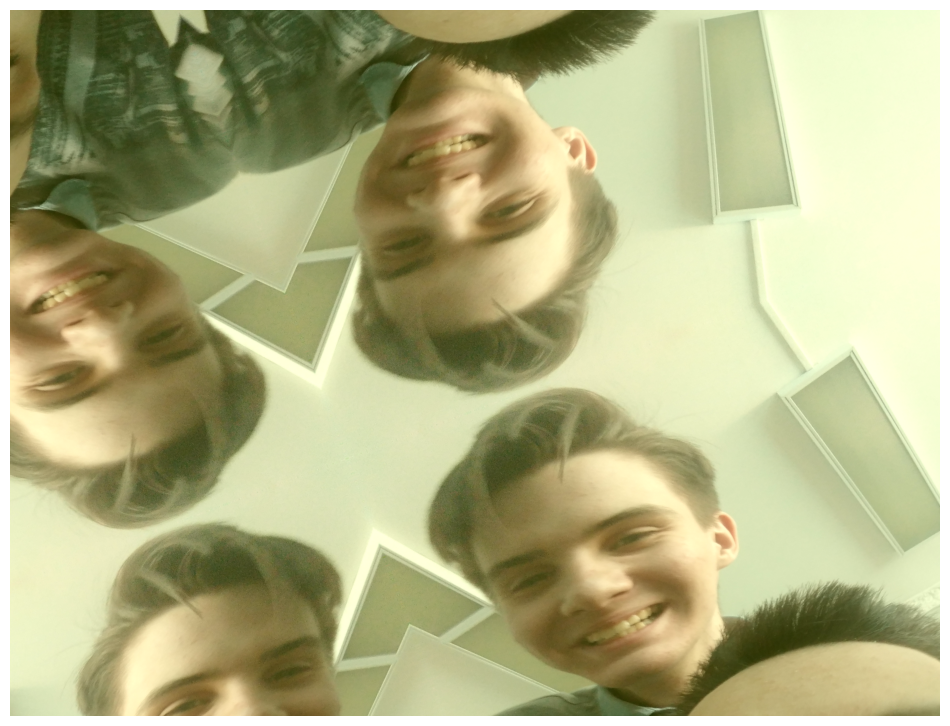

In [198]:
transform = A.Compose([
        A.Transpose(p=1.0),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=(-1, 1), scale_limit=(-0.4, 0.4), rotate_limit=(-75, 75), interpolation=cv2.INTER_LANCZOS4, border_mode=cv2.BORDER_REFLECT, value=0, mask_value=0, shift_limit_x=0.5, shift_limit_y=0.7, rotate_method='largest_box', always_apply=None, p=1),
        A.RandomBrightnessContrast(p=0.3),
        A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
)
transformed = transform(image=image, bboxes=bboxes, category_ids=category_ids)
visualize(
    transformed['image'],
    transformed['bboxes'],
    transformed['category_ids'],
    category_id_to_name,
)